In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

from codecarbon import EmissionsTracker

from utils.basics import get_impact_task, get_impact_tracker, \
    plot_examples_classification, plot_wrong_classification, \
    plot_loss_acc_over_epochs, plot_co2_energy_over_epochs, \
    generate_digit_cvae, train_PCA, generate_digit_pca, \
    train_proba_pixel, generate_digit_proba_pixel
from utils.processes import import_MNIST, \
    expe_simple_MLP, expe_simple_CNN, \
    train_cvae_MLP, train_cvae_CNN, \
    inference_bert, generate_gpt2

# Suppress specific FutureWarning from pandas
import warnings
warnings.filterwarnings(
    "ignore",
    message="The behavior of DataFrame concatenation with empty or all-NA entries is deprecated",
    category=FutureWarning
)

os.makedirs('.emissions_logs/', exist_ok=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
device = 'cpu'
print(f"Using device: {device}")

Using device: cpu


# Basic operations

## First examples

In [2]:
tracker_first_example = EmissionsTracker(save_to_file=False)
tracker_first_example.start()

try:
    _ = 1 + 1 # Replace with code to track
finally:
    emissions_first_example = tracker_first_example.stop()
    print(f"Emissions: {emissions_first_example} kg CO2eq")

[codecarbon WARNING @ 11:22:10] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 11:22:10] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon INFO @ 11:22:10] [setup] RAM Tracking...
[codecarbon INFO @ 11:22:10] [setup] CPU Tracking...
[codecarbon WARNING @ 11:22:10] We saw that you have a Apple M4 Pro but we don't know it. Please contact us.
[codecarbon WARNING @ 11:22:11] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS detected: Please install Intel Power Gadget or enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 11:22:11] CPU Model on constant consumption mode: Apple M4 Pro
[codecarbon WARNING @ 11:22:11] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:22:11] [setup] GPU Tracking...
[codecarbon INFO @ 11:22:11] No GPU found.
[codecarbon INFO @ 11:22:11] The below tracking methods have been 

Emissions: 5.116599413571789e-10 kg CO2eq


## Increase the number of operations

[codecarbon WARNING @ 11:22:11] Multiple instances of codecarbon are allowed to run at the same time.


Emissions for    10000 loops: 4.970804538019648e-10 kg CO2eq
Emissions for    31622 loops: 1.1883856794652338e-09 kg CO2eq
Emissions for   100000 loops: 3.5766244078116143e-09 kg CO2eq
Emissions for   316227 loops: 9.75769704285647e-09 kg CO2eq
Emissions for  1000000 loops: 2.6629125385047265e-08 kg CO2eq
Emissions for  3162277 loops: 6.609751656002632e-08 kg CO2eq
Emissions for 10000000 loops: 1.7979947605656337e-07 kg CO2eq
Emissions for 31622776 loops: 5.598303747365023e-07 kg CO2eq
Emissions for 100000000 loops: 1.7614010308991669e-06 kg CO2eq


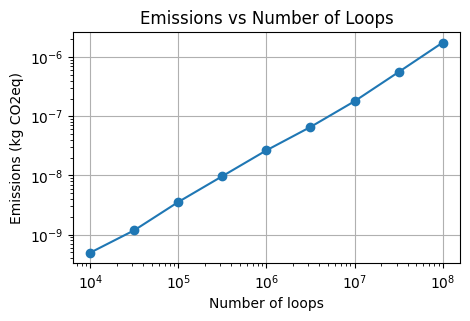

In [3]:
n_loops_tested = np.logspace(4, 8, num=9, dtype=int)
emissions_results = []

for n_loops in n_loops_tested:

    tracker = EmissionsTracker(project_name=f'Simple_loop_{n_loops}', log_level='error', 
                               output_dir='.emissions_logs', output_file='simple_loop.csv')
    tracker.start()

    try:
        for _ in range(n_loops):
            _ = 1 + 1
    finally:
        emissions = tracker.stop()
        emissions_results.append(emissions)
        print(f"Emissions for {n_loops:>8} loops: {emissions} kg CO2eq")

plt.figure(figsize=(5, 3))
plt.plot(n_loops_tested, emissions_results, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of loops')
plt.ylabel('Emissions (kg CO2eq)')
plt.title('Emissions vs Number of Loops')
plt.grid()
plt.show()

## Tasks

In [4]:
# Create an emissions tracker
tracker_test = EmissionsTracker(project_name='Test', log_level='error', 
                                output_dir='.emissions_logs', output_file='test.json')

# Start a new task
tracker_test.start_task(task_name="test1")
for _ in range(int(1e3)):
    _ = 1 + 1
emission_1 = tracker_test.stop_task()

# Start another task
tracker_test.start_task(task_name="test2")
for _ in range(int(1e6)):
    _ = 1 + 1
emission_2 = tracker_test.stop_task()

# Stop the tracker
emissions_test = tracker_test.stop()

# Print impact results
print("----- Impact test 1: -----")
impact1 = get_impact_task(emission_1, verbose=True)
print("\n----- Impact test 2: -----")
impact2 = get_impact_task(emission_2, verbose=True)
print("\n----- Impact tracker total: -----")
impact_tracker = get_impact_tracker(tracker_test, verbose=True)

----- Impact test 1: -----
emissions_kgCO2eq: 9.526339237386776e-10
total_energy_kWh: 1.6999481142395073e-08
cpu_energy_kWh: 1.497829927959376e-08
gpu_energy_kWh: 0.0
ram_energy_kWh: 2.0211818628013136e-09
cpu_power_W: 42.5
gpu_power_W: 0.0
ram_power_W: 6.0
water_L: 0.0

----- Impact test 2: -----
emissions_kgCO2eq: 2.5004130006484992e-08
total_energy_kWh: 4.4619158097905014e-07
cpu_energy_kWh: 3.9105706608905986e-07
gpu_energy_kWh: 0.0
ram_energy_kWh: 5.513451488999029e-08
cpu_power_W: 42.5
gpu_power_W: 0.0
ram_power_W: 6.0
water_L: 0.0

----- Impact tracker total: -----
total_emissions_kgCO2eq: 2.6549738609203267e-08
total_energy_kWh: 4.737725264405729e-07
total_cpu_energy_kWh: 4.1533321960337675e-07
total_gpu_energy_kWh: 0.0
total_ram_energy_kWh: 5.843930683719615e-08
cpu_power_W: 42.5
gpu_power_W: 0.0
ram_power_W: 6.0
total_water_L: 0.0
cpu_model: Apple M4 Pro
gpu_model: None
ram_total_size: 48.0


# Setup MNIST Experiment

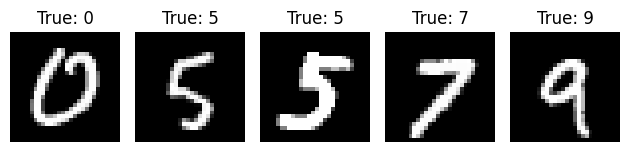

In [5]:
train_loader, test_loader, train_dataset, test_dataset = import_MNIST(batch_size_train=64)

# Flatten MNIST images
X_train = train_dataset.data.numpy().reshape(-1, 28*28)
y_train = train_dataset.targets.numpy()

# Classification tasks

## Expe - Simple MLP

In [6]:
hidden_dims_tested = [
    [32, 16], 
    [64, 32],
    [128, 64, 32],
    [256, 128, 64]
]

all_res_epochs_mlp, all_summaries_mlp, all_models_mlp, all_labels_mlp = \
    expe_simple_MLP(
        hidden_dims_tested, train_loader, test_loader,
        device, nbr_epochs=10
    )

> Training SimpleMLP with hidden dimensions: [32, 16]
Skipping training SimpleMLP_32_16 as log already exists.
> Training SimpleMLP with hidden dimensions: [64, 32]
Skipping training SimpleMLP_64_32 as log already exists.
> Training SimpleMLP with hidden dimensions: [128, 64, 32]
Skipping training SimpleMLP_128_64_32 as log already exists.
> Training SimpleMLP with hidden dimensions: [256, 128, 64]
Skipping training SimpleMLP_256_128_64 as log already exists.


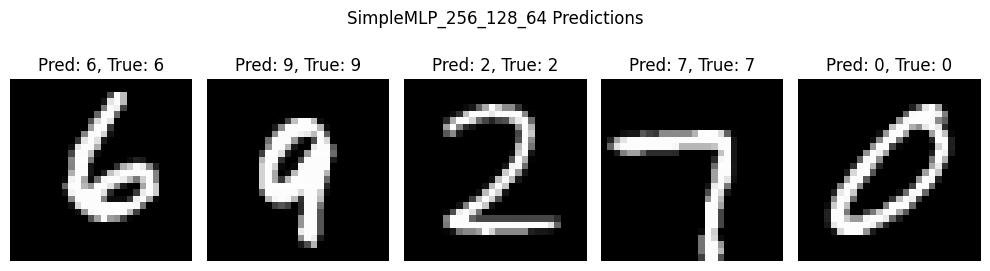

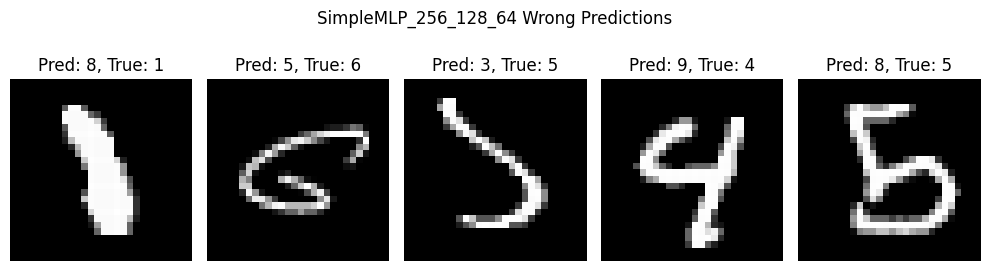

In [7]:
# Example of prediction
idx_model = -1  # Last trained model
plot_examples_classification(all_models_mlp[idx_model], test_dataset, device, 
                             n=5, suptitle=all_labels_mlp[idx_model] + " Predictions")
plot_wrong_classification(all_models_mlp[idx_model], test_dataset, device, 
                          n=5, suptitle=all_labels_mlp[idx_model] + " Wrong Predictions")
plt.show()

## Expe - Simple CNN

In [8]:
hidden_channels_tested = [
    [8], 
    [32],
    [32, 32],
    [64, 64, 64]
]

all_res_epochs_cnn, all_summaries_cnn, all_models_cnn, all_labels_cnn = \
    expe_simple_CNN(
        hidden_channels_tested, train_loader, test_loader,
        device, nbr_epochs=10
    )

> Training SimpleCNN with hidden channels: [8]
Skipping training SimpleCNN_8 as log already exists.
> Training SimpleCNN with hidden channels: [32]
Skipping training SimpleCNN_32 as log already exists.
> Training SimpleCNN with hidden channels: [32, 32]
Skipping training SimpleCNN_32_32 as log already exists.
> Training SimpleCNN with hidden channels: [64, 64, 64]
Skipping training SimpleCNN_64_64_64 as log already exists.


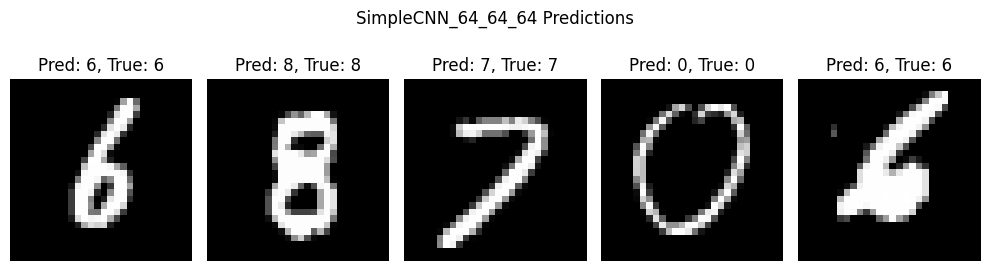

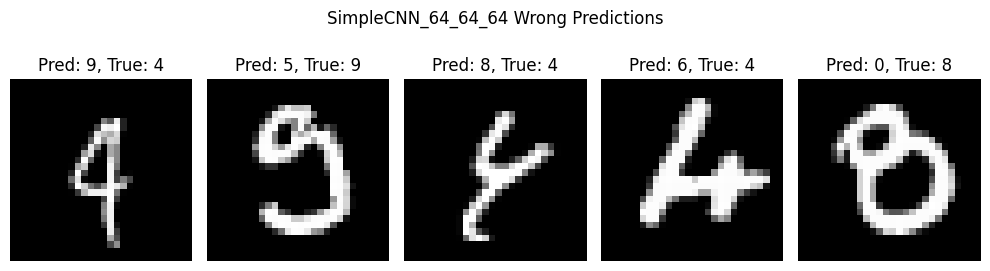

In [9]:
# Example of prediction
idx_model = -1  # Last trained model
plot_examples_classification(all_models_cnn[idx_model], test_dataset, device, 
                             n=5, suptitle=all_labels_cnn[idx_model] + " Predictions")
plot_wrong_classification(all_models_cnn[idx_model], test_dataset, device, 
                          n=5, suptitle=all_labels_cnn[idx_model] + " Wrong Predictions")
plt.show()

## Plots

In [10]:
# Combine summaries into a single DataFrame
summaries = pd.concat(
    [pd.DataFrame(all_summaries_mlp), pd.DataFrame(all_summaries_cnn)]
).reset_index(drop=True)

# Manage colors for pairplot
palette = {}
for i, name in enumerate(all_labels_mlp):
    palette[name] = sns.color_palette("autumn", len(all_labels_mlp)).pop(i)
for i, name in enumerate(all_labels_cnn):
    palette[name] = sns.color_palette("winter", len(all_labels_cnn)).pop(i)

### Summary

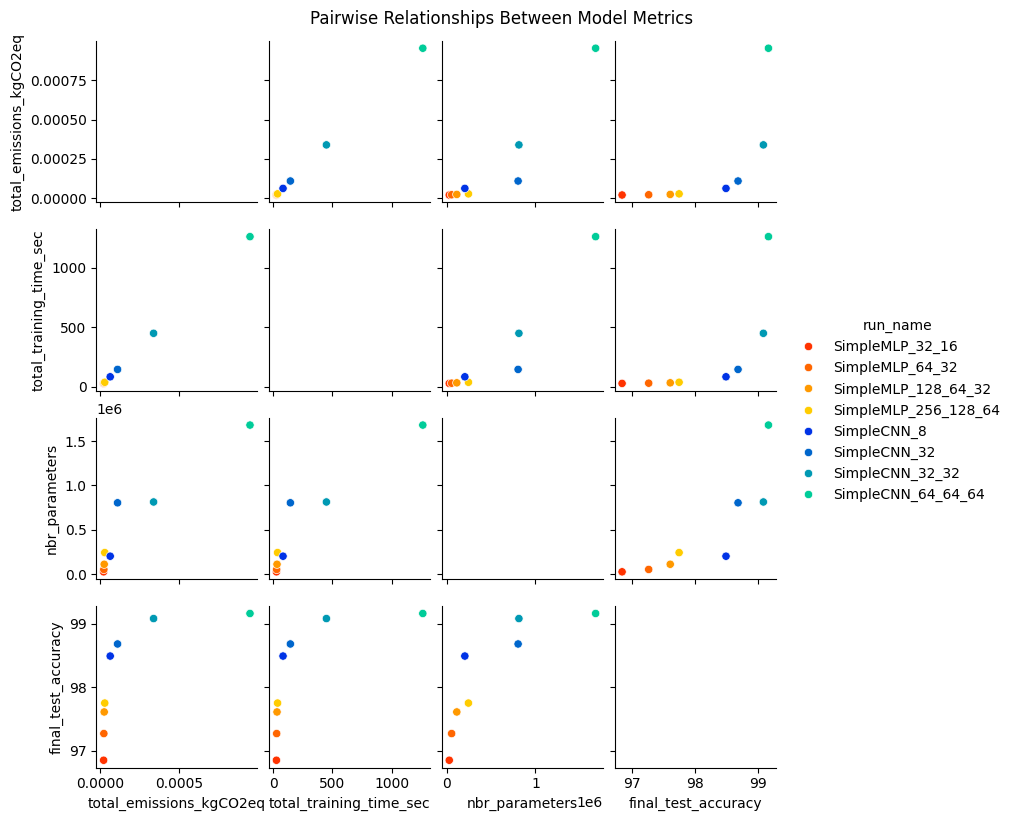

In [11]:
# Select columns to plot
cols_to_plot = [
    'total_emissions_kgCO2eq', 
    # 'total_energy_kWh', 
    'total_training_time_sec', 
    'nbr_parameters',
    'final_test_accuracy', 
    # 'final_train_loss',
]

# Pairplot of metrics
sns.pairplot(summaries[cols_to_plot + ['run_name']], hue="run_name", 
             diag_kind='', corner=False, height=2, palette=palette)
plt.suptitle("Pairwise Relationships Between Model Metrics", y=1.02)
plt.show()

### Over epochs

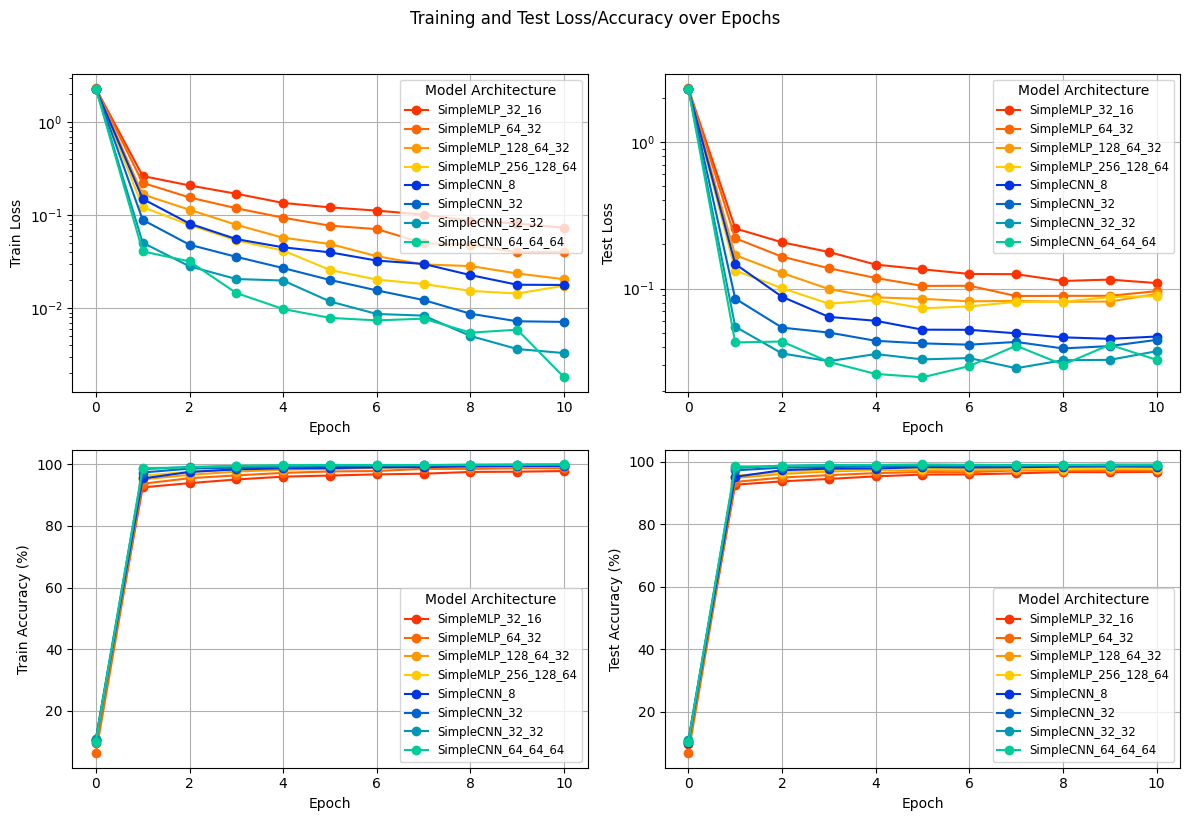

In [12]:
plot_loss_acc_over_epochs(
    all_res_epochs_mlp + all_res_epochs_cnn, 
    all_labels_mlp + all_labels_cnn, 
    palette
)

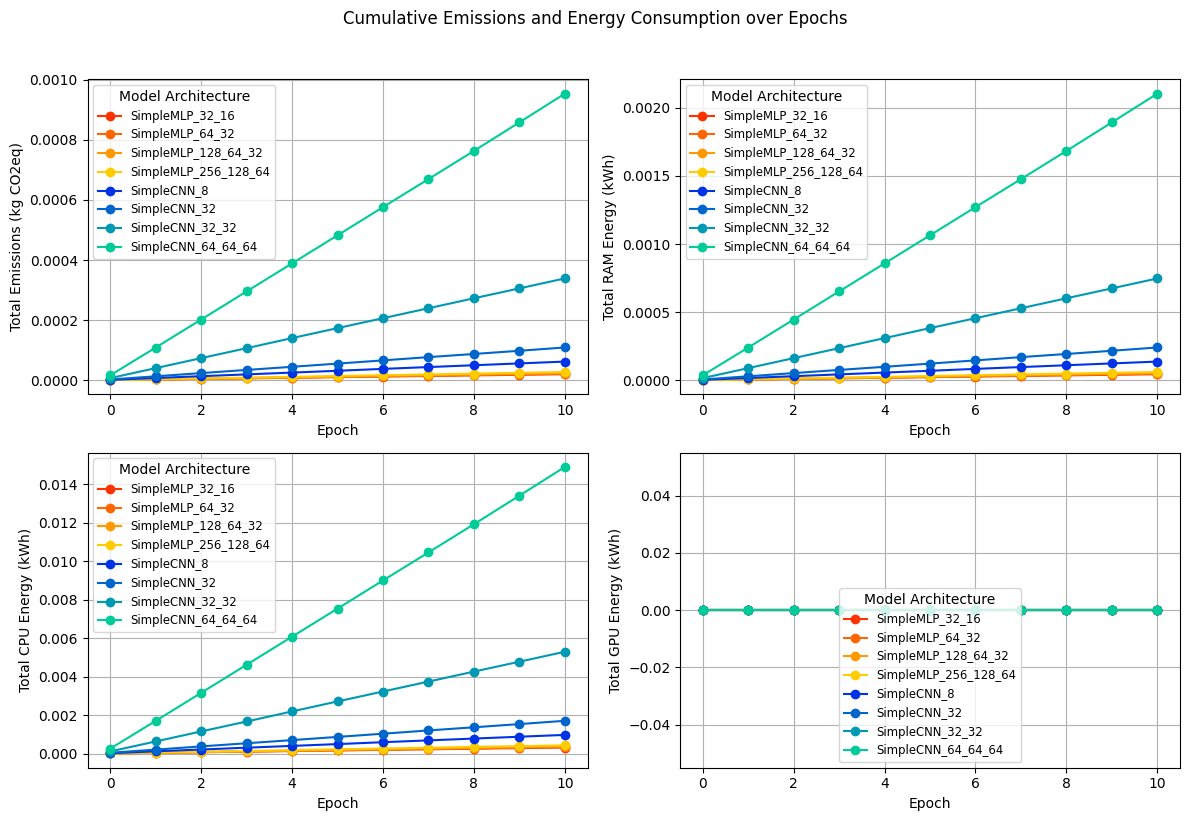

In [13]:
plot_co2_energy_over_epochs(
    all_res_epochs_mlp + all_res_epochs_cnn, 
    all_labels_mlp + all_labels_cnn, 
    palette
)

# Image generation tasks

## CVAE with MLP

In [14]:
hidden_dims = [400, 100]
latent_dim = 20

cvae_mlp, emission_train_cvae_mlp = train_cvae_MLP(
    hidden_dims, latent_dim, train_loader, device, nbr_epochs=10
)

CVAE_MLP number of parameters: 720024
Loading pre-trained CVAE_MLP model.
--------------------------------
CVAE_MLP Training Emissions:
total_emissions_kgCO2eq: 3.03e-05
total_energy_kWh: 5.41e-04
total_cpu_energy_kWh: 4.74e-04
total_gpu_energy_kWh: 0.00e+00
total_ram_energy_kWh: 6.69e-05
cpu_power_W: 42.500
gpu_power_W: 0.00e+00
ram_power_W: 6.000
total_water_L: 0.00e+00
cpu_model: Apple M4 Pro
gpu_model: None
ram_total_size: 48.000
total_training_time_sec: 40.136


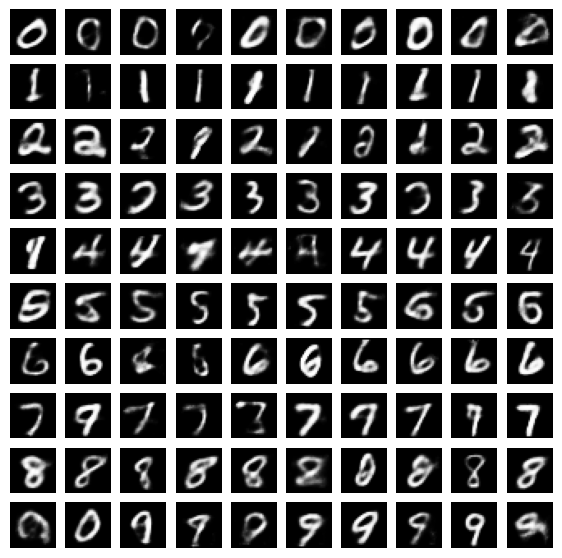

total_emissions_kgCO2eq: 1.60e-09
total_energy_kWh: 2.85e-08
total_cpu_energy_kWh: 2.50e-08
total_gpu_energy_kWh: 0.00e+00
total_ram_energy_kWh: 3.44e-09
cpu_power_W: 42.500
gpu_power_W: 0.00e+00
ram_power_W: 6.000
total_water_L: 0.00e+00
cpu_model: Apple M4 Pro
gpu_model: None
ram_total_size: 48.000


In [15]:
all_imgs_mlp, emission_gen_cvae_mlp = generate_digit_cvae(
    cvae_mlp, n_samples=10, device=device, track_emissions=True
)
for k, v in emission_gen_cvae_mlp.items():
    if isinstance(v, float):
        message = f"{k}: {v:.3f}" if v >= 1e-2 else f"{k}: {v:.2e}"
    else:
        message = f"{k}: {v}"
    print(message)

## CVAE with CNN

In [16]:
hidden_channels = [32, 64, 128]
latent_dim = 20

cvae_cnn, emission_train_cvae_cnn = train_cvae_CNN(
    hidden_channels, latent_dim, train_loader, device, nbr_epochs=5
)

CVAE_CNN number of parameters: 1969609
Loading pre-trained CVAE_CNN model.
--------------------------------
CVAE_CNN Training Emissions:
total_emissions_kgCO2eq: 4.78e-04
total_energy_kWh: 8.53e-03
total_cpu_energy_kWh: 7.47e-03
total_gpu_energy_kWh: 0.00e+00
total_ram_energy_kWh: 1.06e-03
cpu_power_W: 42.500
gpu_power_W: 0.00e+00
ram_power_W: 6.000
total_water_L: 0.00e+00
cpu_model: Apple M4 Pro
gpu_model: None
ram_total_size: 48.000
total_training_time_sec: 633.066


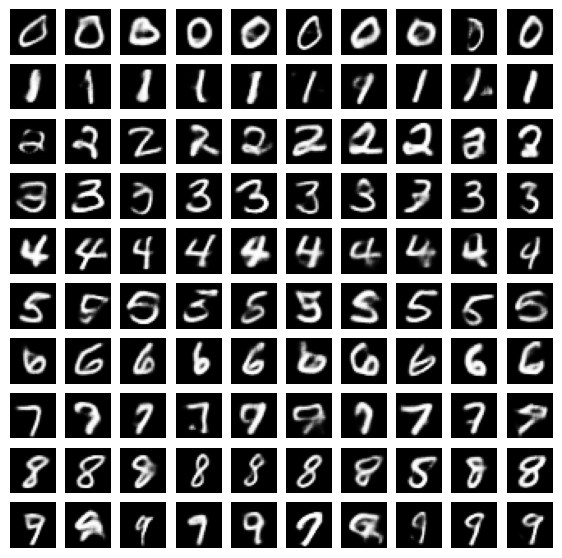

total_emissions_kgCO2eq: 1.55e-08
total_energy_kWh: 2.77e-07
total_cpu_energy_kWh: 2.43e-07
total_gpu_energy_kWh: 0.00e+00
total_ram_energy_kWh: 3.41e-08
cpu_power_W: 42.500
gpu_power_W: 0.00e+00
ram_power_W: 6.000
total_water_L: 0.00e+00
cpu_model: Apple M4 Pro
gpu_model: None
ram_total_size: 48.000


In [17]:
all_imgs_cnn, emission_gen_cvae_cnn = generate_digit_cvae(
    cvae_cnn, n_samples=10, device=device, track_emissions=True
)
for k, v in emission_gen_cvae_cnn.items():
    if isinstance(v, float):
        message = f"{k}: {v:.3f}" if v >= 1e-2 else f"{k}: {v:.2e}"
    else:
        message = f"{k}: {v}"
    print(message)

## PCA

PCA Training Emissions (kgCO2eq): 4.17e-07


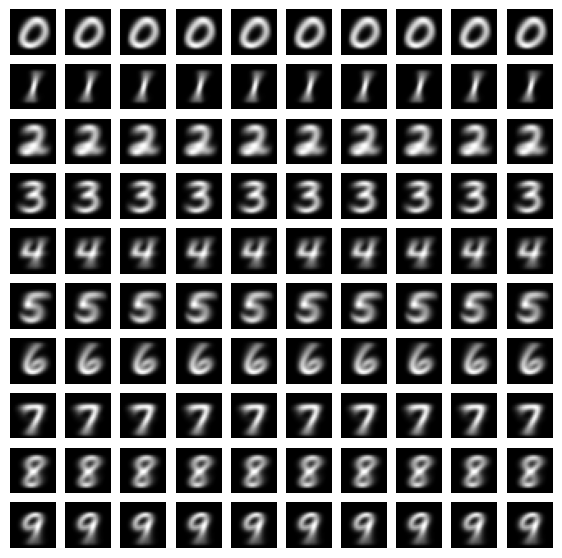

PCA Generation Emissions (kgCO2eq): 9.02e-10


In [18]:
all_pcas, emission_train_PCA = train_PCA(X_train, y_train, n_components=50, track_emissions=True)
print(f"PCA Training Emissions (kgCO2eq): {emission_train_PCA['total_emissions_kgCO2eq']:.2e}")

all_imgs, emission_info = generate_digit_pca(all_pcas, n_samples=10, track_emissions=True)
print(f"PCA Generation Emissions (kgCO2eq): {emission_info['total_emissions_kgCO2eq']:.2e}")

Probabilistic Pixel Training Emissions (kgCO2eq): 5.61e-08


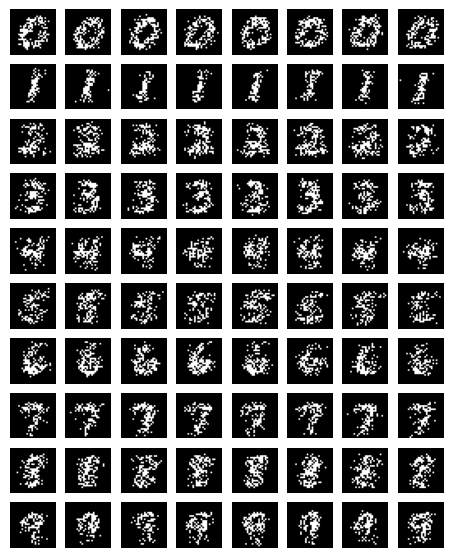

Probabilistic Pixel Generation Emissions (kgCO2eq): 1.81e-09


In [19]:
all_p, emission_info = train_proba_pixel(X_train, y_train, track_emissions=True)
print(f"Probabilistic Pixel Training Emissions (kgCO2eq): "
      f"{emission_info['total_emissions_kgCO2eq']:.2e}")

all_imgs, emission_info = generate_digit_proba_pixel(all_p, n_samples=8, track_emissions=True)
print(f"Probabilistic Pixel Generation Emissions (kgCO2eq): "
      f"{emission_info['total_emissions_kgCO2eq']:.2e}")

# Text generation tasks

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM

# Load pretrained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForMaskedLM.from_pretrained("bert-base-uncased").to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"BERT number of parameters: {num_params}")

model.eval()

# Example: mask a word
text_examples = [
    "The capital of France is [MASK].",
    "The largest planet in our solar system is [MASK].",
    "The most passionate programming language is [MASK]."
]

for text in text_examples:

    predicted_token, emission_bert = inference_bert(
        text, model, tokenizer, device
    )


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT number of parameters: 109514298

--------------------------------

Original text: The capital of France is [MASK].
Predicted token (top 5): ['paris (12.3)', 'lille (10.6)', 'lyon (10.5)', 'marseille (10.1)', 'tours (9.7)']
Filled sentence: The capital of France is paris.

  > BERT Prediction Emissions: 7.14e-07 kg CO2eq

--------------------------------

Original text: The largest planet in our solar system is [MASK].
Predicted token (top 5): ['earth (10.3)', 'pluto (10.2)', 'jupiter (9.9)', 'mars (9.9)', 'saturn (9.3)']
Filled sentence: The largest planet in our solar system is earth.

  > BERT Prediction Emissions: 3.81e-08 kg CO2eq

--------------------------------

Original text: The most passionate programming language is [MASK].
Predicted token (top 5): ['java (10.5)', 'python (9.9)', 'c (9.8)', 'english (9.0)', 'php (7.4)']
Filled sentence: The most passionate programming language is java.

  > BERT Prediction Emissions: 3.96e-08 kg CO2eq


In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load GPT-2 tokenizer and model
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)

num_params = sum(p.numel() for p in gpt2_model.parameters() if p.requires_grad)
print(f"GPT-2 number of parameters: {num_params}")

gpt2_model.eval()

# Example prompt
prompt_examples = [
    "Once upon a time in a galaxy far, far away",
    "In the future, artificial intelligence will",
    "The secret to a happy life is"
]

for prompt in prompt_examples:

    generated_text, nbr_tokens_generated, emission_gpt2 = generate_gpt2(
        prompt, gpt2_model, gpt2_tokenizer, device, max_length=200
    )


GPT-2 number of parameters: 124439808

--------------------------------

Prompt: Once upon a time in a galaxy far, far away
Generated (200 tokens): Once upon a time in a galaxy far, far away, with nothing but the speed and precision to support an army of a hundred thousand warriors. The last two years have been a blur of battle for the galaxy. Now the Republic has a very different plan, one that calls for action.

This mission is your first step in your campaign to rule over all of this new world.


The Battle for Terra Edit

A New Hope of the Warring Tribes of Earth Edit

It has been over thirty years since the events of this game, and it is time for a new beginning.

Your new starting planet is Mars and the Republic of the Republic of Terra has joined you in war on Terra. In an era of civil war and military expansion, your only viable defense is your unique weapon, the M8 Starfighter. The M8 Starfighter is designed with a unique modular cockpit that is capable of taking on the multit